In [ ]:
# SELECT country, IF(rand() <0.5, 'Group A', 'Group B') as type
# FROM `bigquery-public-data.world_bank_global_population.population_by_country`

# BQML Data prep for casual impact example

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [49]:
REGION = 'us-central1'
EXPERIMENT = 'control_group1'
SERIES = 'causal_impact_4'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 9

### packages

In [37]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from google.cloud import aiplatform as vertex_ai

In [38]:
bq_client = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

### BQ dataset

In [39]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq_client.create_dataset(dataset = ds, exists_ok = True)

In [40]:
ds.dataset_id

'causal_impact_4'

In [41]:
ds.full_dataset_id

'hybrid-vertex:causal_impact_4'

In [42]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE1}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,107,2014-06-06 13:02:01+00:00,2014-06-06 13:03:48+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,16692,Subscriber,1977,male
1,1105,2013-08-24 17:03:52+00:00,2013-08-24 17:22:17+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,15352,Customer,<NA>,unknown
2,990,2014-04-25 11:52:28+00:00,2014-04-25 12:08:58+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,20194,Subscriber,1973,male
3,138,2015-08-20 16:58:57+00:00,2015-08-20 17:01:16+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,21002,Subscriber,1977,male
4,78,2014-09-13 13:18:36+00:00,2014-09-13 13:19:54+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,19259,Customer,<NA>,unknown


In [43]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE2}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


In [44]:
# station="Pershing Square"
# station="Broadway"
# station="Chambers"
station="Lafayette"
# station="Cleveland"

In [45]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender,
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%{station}%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%{station}%'
        GROUP BY name
    )
SELECT * EXCEPT(name, ratio_gender, capacity),
    IFNULL(ratio_gender, 0) AS ratio_gender,
    IFNULL(capacity, 0) AS capacity,
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.917

In [46]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty
CONTROL_GROUP='control_group'

In [50]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Clermont Ave & Lafayette Ave,21019,2013-07-01,2016-09-30
1,Cumberland St & Lafayette Ave,28674,2013-07-01,2016-09-27
2,Lafayette Ave & Classon Ave,20345,2013-07-01,2016-09-30
3,Lafayette Ave & Fort Greene Pl,29480,2013-07-01,2016-09-30
4,Lafayette Ave & St James Pl,20646,2013-07-01,2016-09-30
5,Lafayette St & E 8 St,277060,2013-07-01,2016-08-22
6,Lafayette St & Jersey St,152363,2013-07-01,2016-09-30
7,Lafayette St & Jersey St N,4249,2016-07-01,2016-07-19
8,Marcy Ave & Lafayette Ave,2433,2015-08-25,2016-09-30


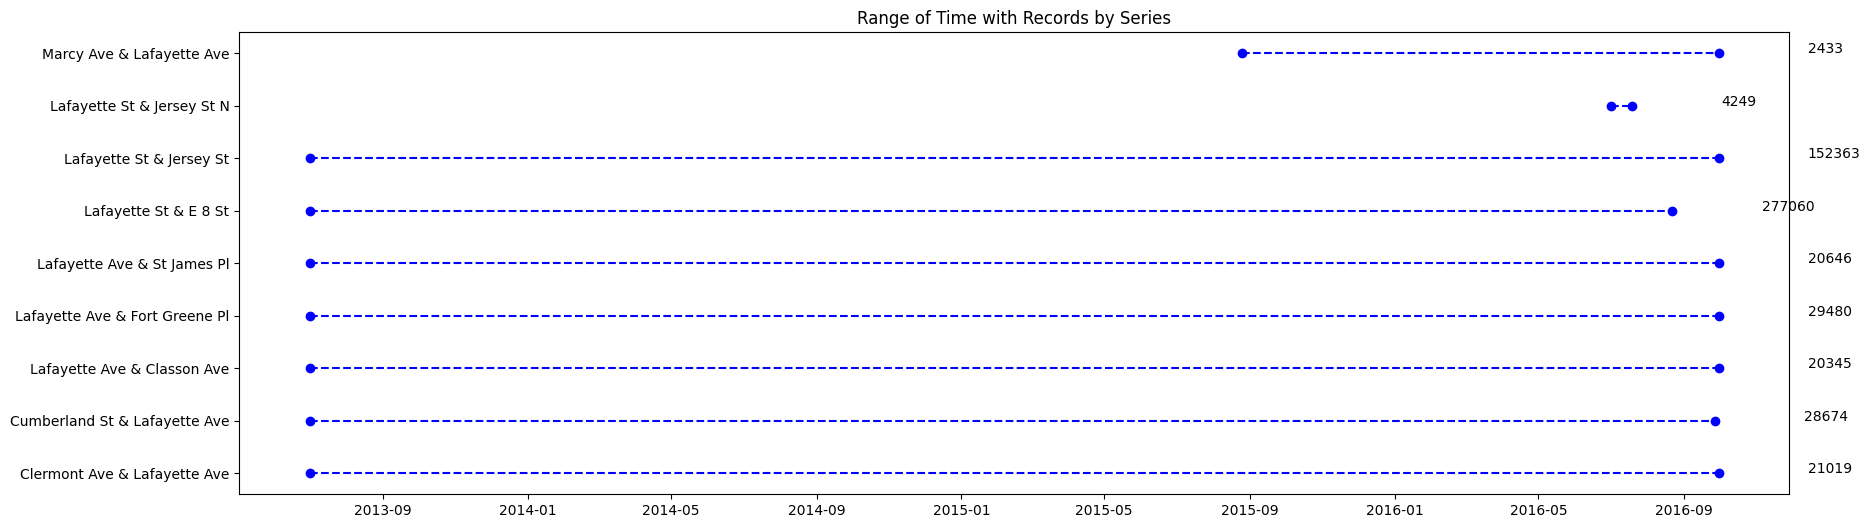

In [51]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [52]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

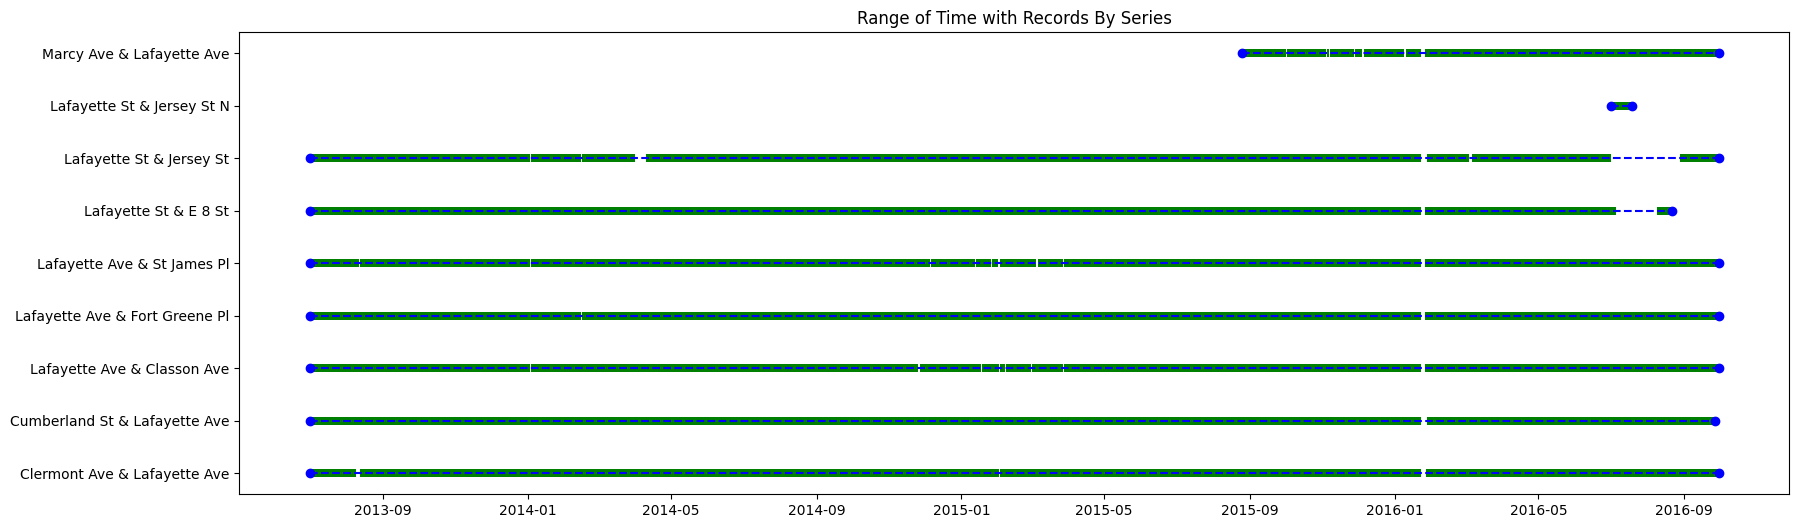

In [53]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Splits and Control Groups

In [54]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 7
forecast_test_length = 70
forecast_val_length = 70

CONTROL_GROUP='control_group'

In [55]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date,
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-05-14,2016-07-23,2016-09-30


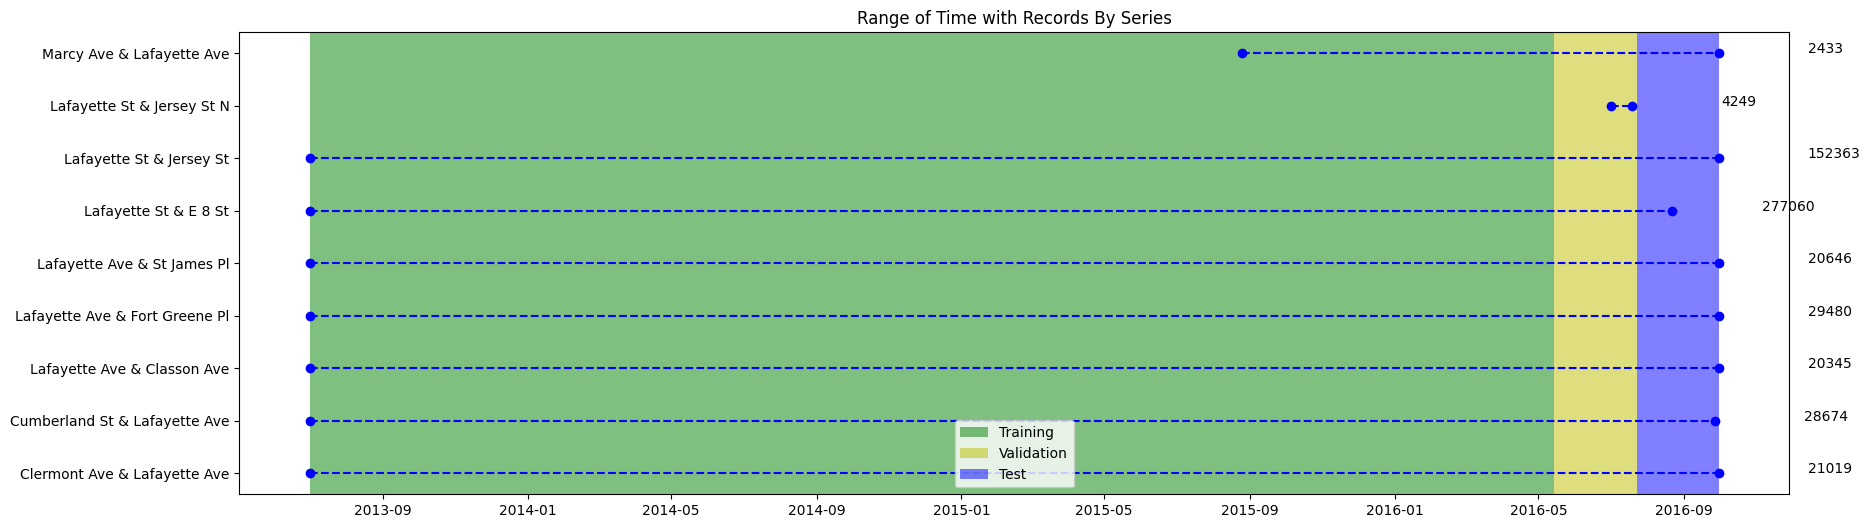

In [56]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting

In [57]:
CONTROL_GROUP='control_group'

In [58]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits,
       IF(rand() <0.5, 'Group_A', 'Group_B') as {CONTROL_GROUP}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

2.105

### review forecasting data

In [59]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        COUNTIF({CONTROL_GROUP}='Group_A') as Group_A,
        COUNTIF({CONTROL_GROUP}='Group_B') as Group_B,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,Group_A,Group_B,num_trips
0,Clermont Ave & Lafayette Ave,1035,70,70,574,601,21019
1,Cumberland St & Lafayette Ave,1041,70,67,604,574,28674
2,Lafayette Ave & Classon Ave,1032,70,70,606,566,20345
3,Lafayette Ave & Fort Greene Pl,1041,70,70,600,581,29480
4,Lafayette Ave & St James Pl,1030,70,70,567,603,20646
5,Lafayette St & E 8 St,1044,53,13,544,566,277060
6,Lafayette St & Jersey St,1027,48,33,563,545,152363
7,Lafayette St & Jersey St N,0,19,0,13,6,4249
8,Marcy Ave & Lafayette Ave,245,70,70,188,197,2433


In [61]:
query = f"""
SELECT splits, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY splits
"""
bq_client.query(query = query).to_dataframe()

,splits,Count,Percentage
0,TRAIN,7495,88.197223
1,VALIDATE,540,6.354436
2,TEST,463,5.448341


In [62]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       7495
VALIDATE     540
TEST         463
dtype: int64

In [63]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

8498

In [64]:
query = f"""
SELECT {CONTROL_GROUP}, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY {CONTROL_GROUP}
"""
bq_client.query(query = query).to_dataframe()

,control_group,Count,Percentage
0,Group_A,4259,50.117675
1,Group_B,4239,49.882325


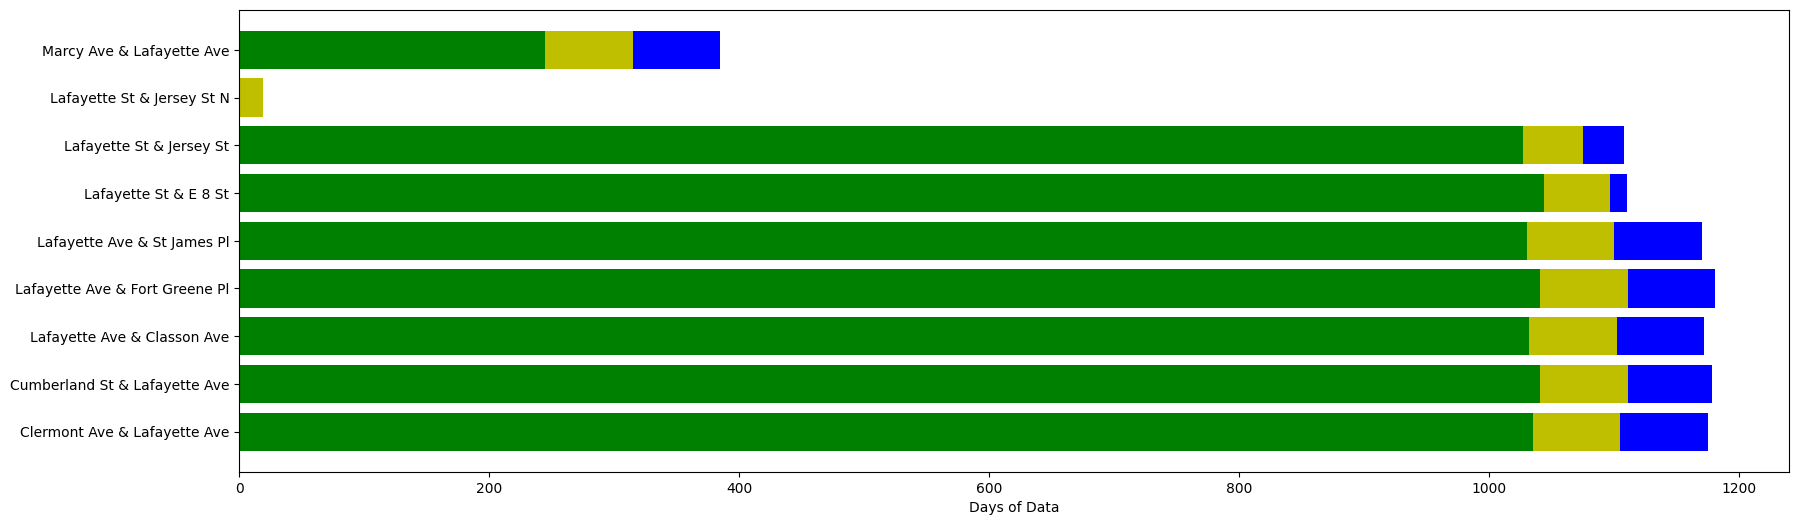

In [65]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

In [66]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-05-14,2016-07-23,2016-09-30


### check for duplicates

In [67]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

,start_station_name,starttime,records


## review time series

In [68]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

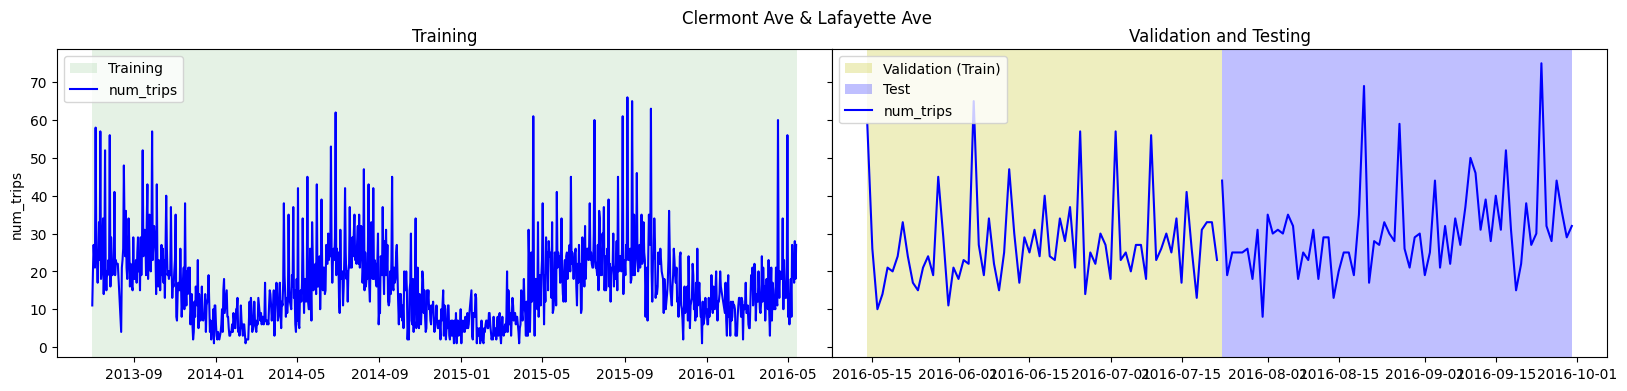

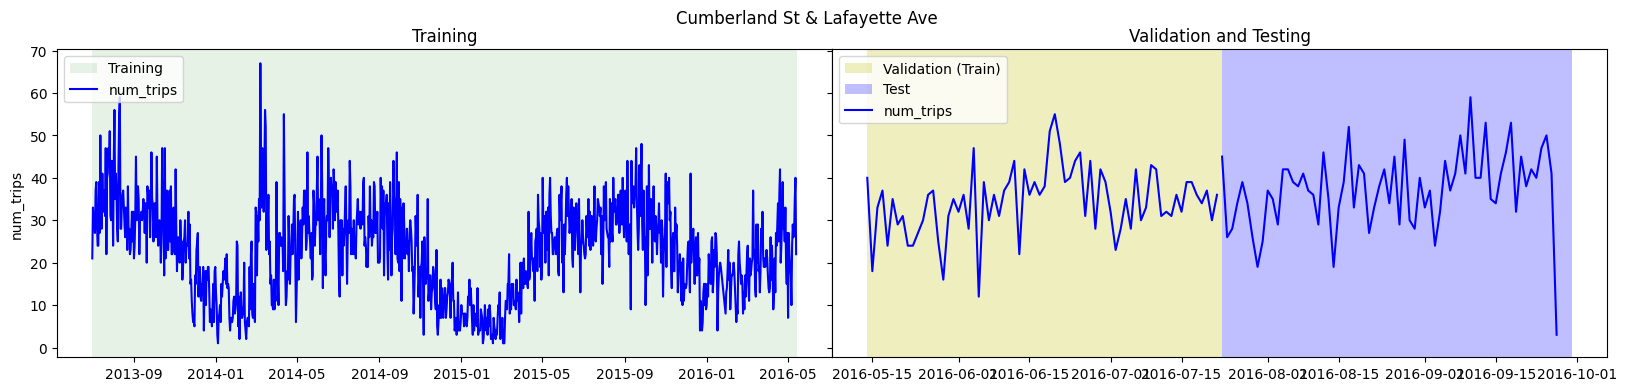

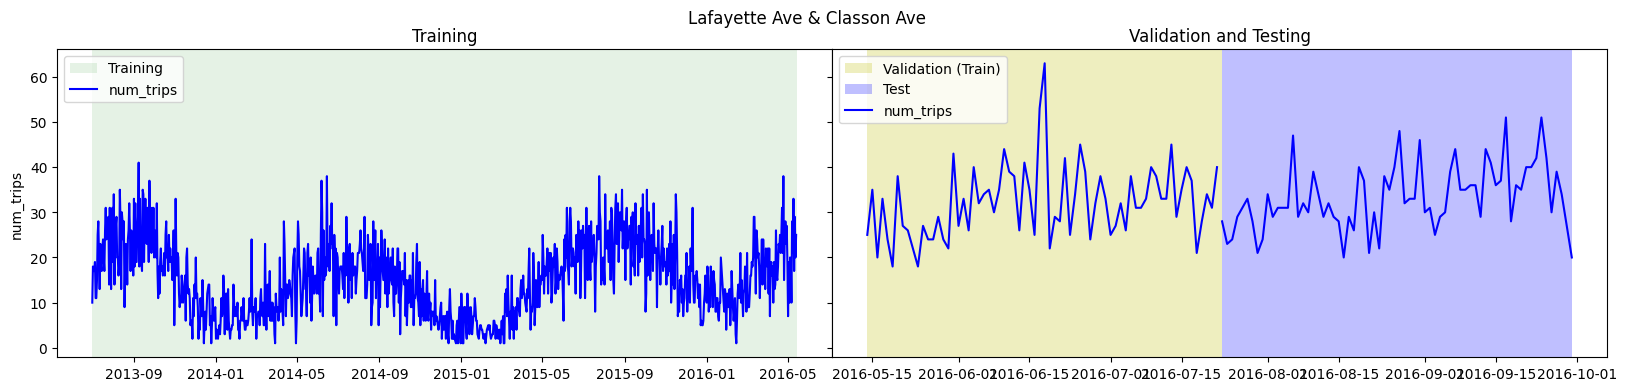

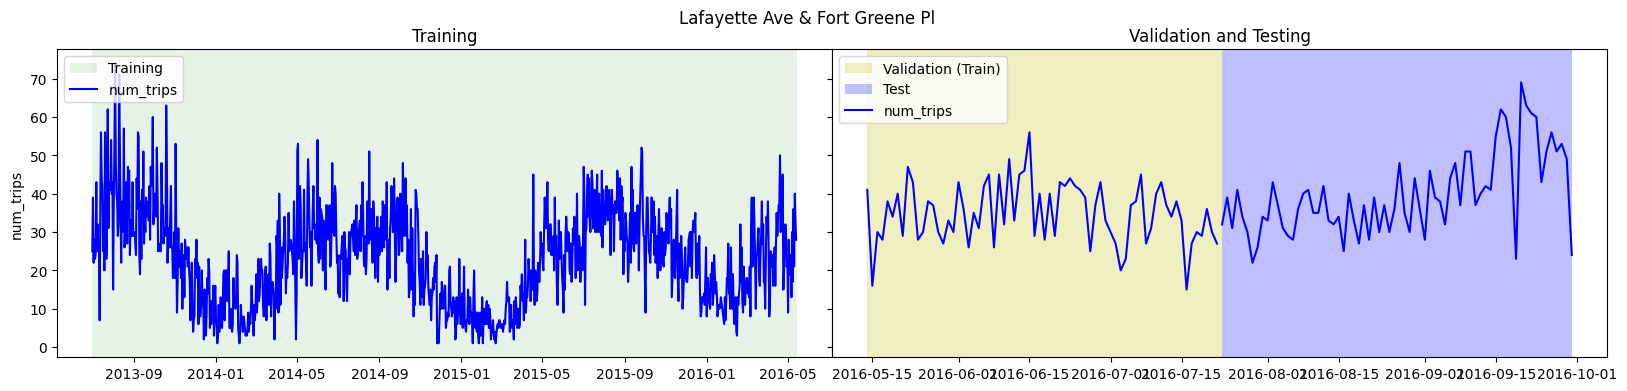

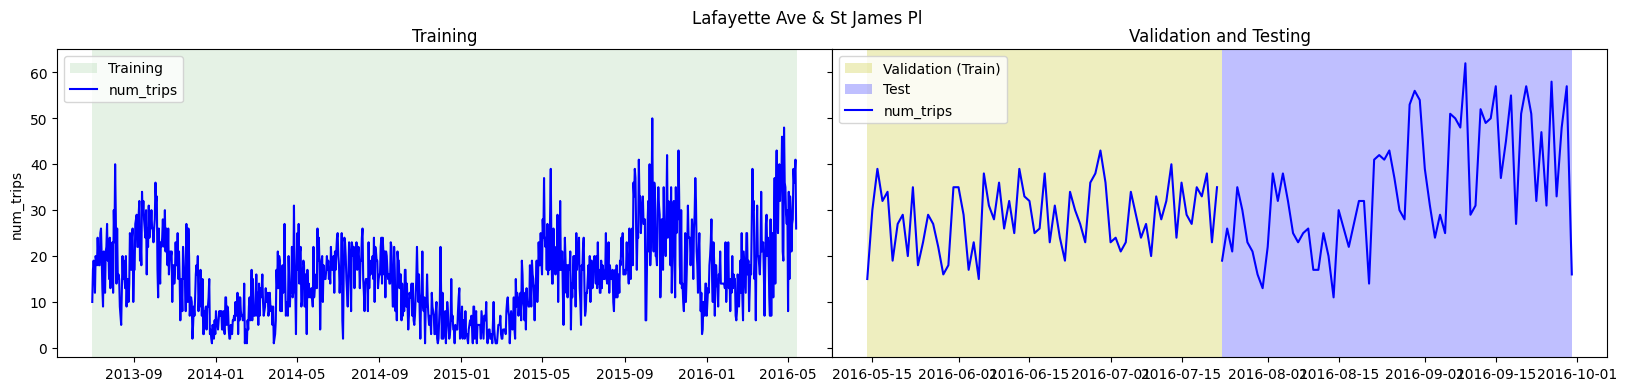

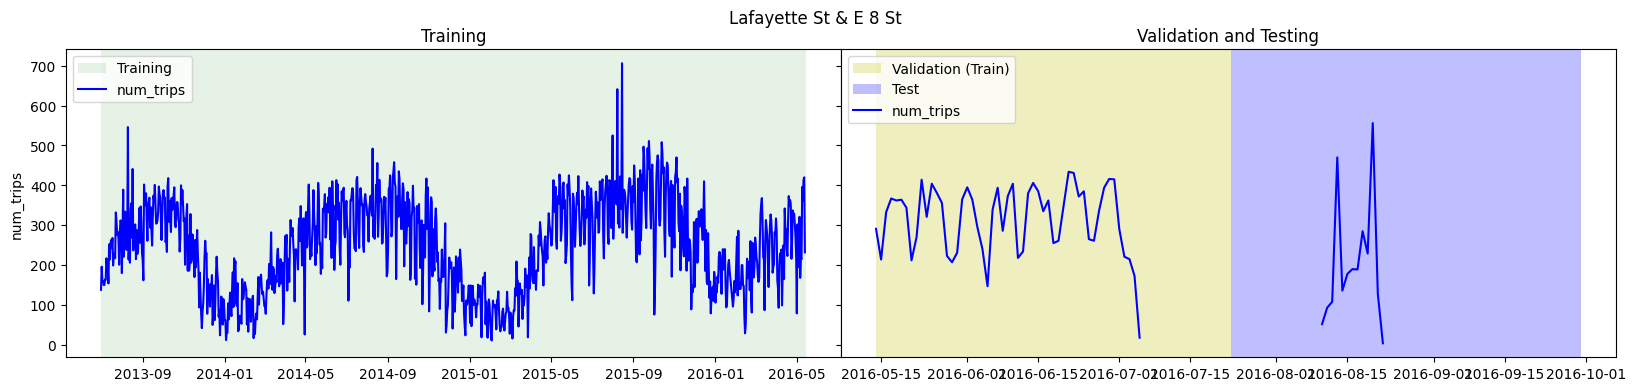

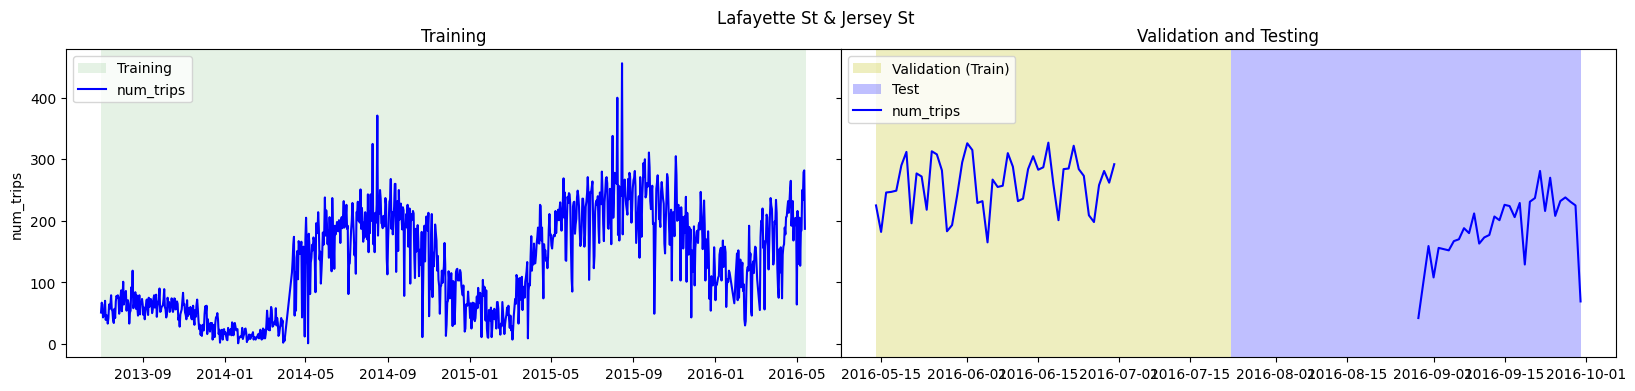

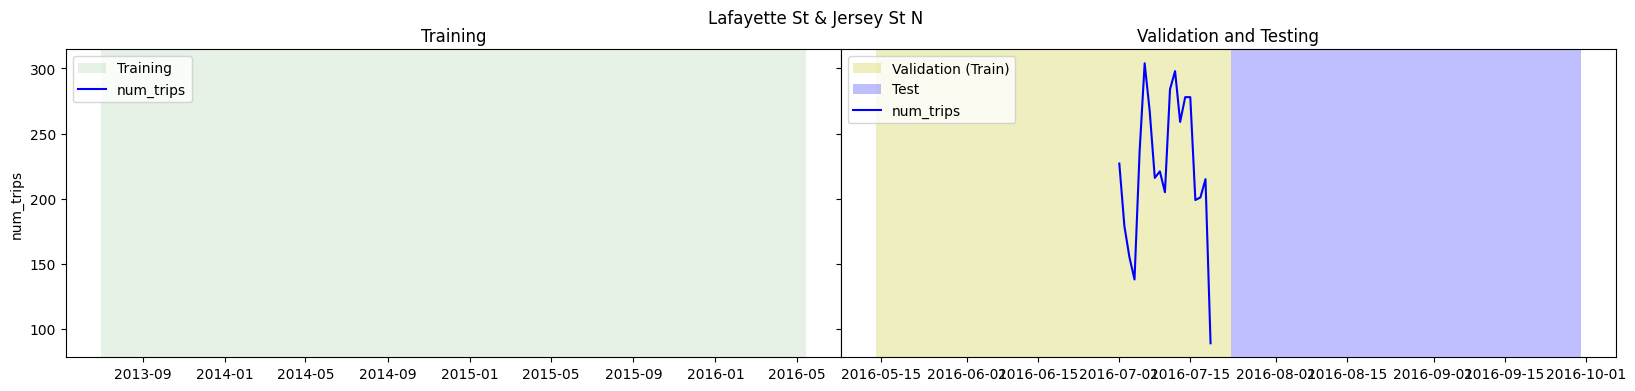

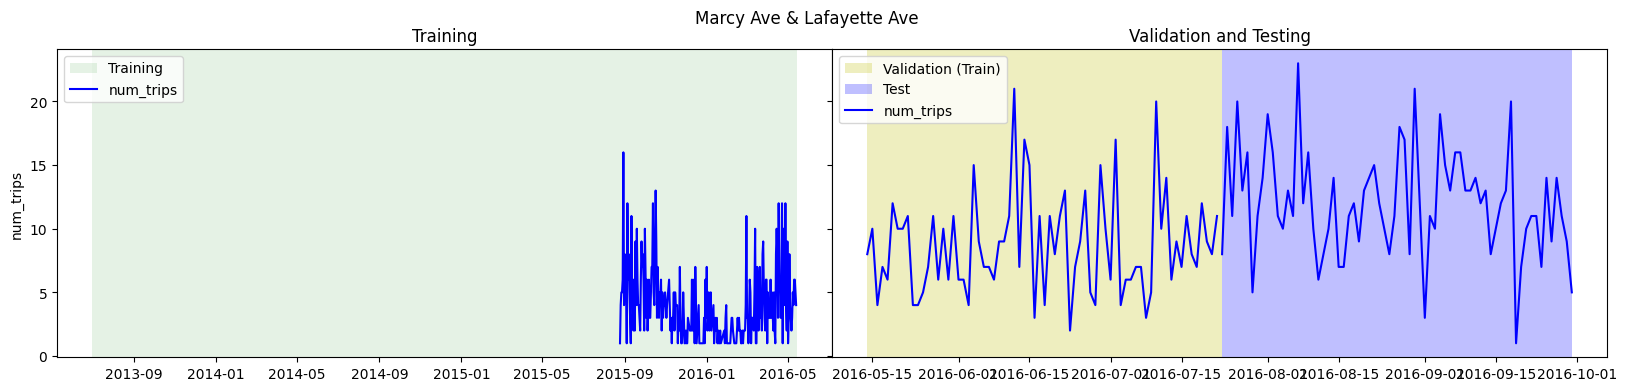

In [69]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

## Control Group Datasets

In [70]:
CONTROL_GROUP='control_group'
CONTROL_GROUP_A="Group_A"
CONTROL_GROUP_B="Group_B"

BQ_TABLE_GROUP_A="control_group1_grp_a"
BQ_TABLE_GROUP_B="control_group1_grp_b"

In [71]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}` AS
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE {CONTROL_GROUP} = '{CONTROL_GROUP_A}'
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.306

In [72]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}` AS
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE {CONTROL_GROUP} = '{CONTROL_GROUP_B}'
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.329

## Review forecast data - Control Group A

In [73]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Clermont Ave & Lafayette Ave,509,35,30,10185
1,Cumberland St & Lafayette Ave,542,33,29,14502
2,Lafayette Ave & Classon Ave,537,38,31,10613
3,Lafayette Ave & Fort Greene Pl,531,37,32,15107
4,Lafayette Ave & St James Pl,502,33,32,9862
5,Lafayette St & E 8 St,513,26,5,134995
6,Lafayette St & Jersey St,530,22,11,76472
7,Lafayette St & Jersey St N,0,13,0,2972
8,Marcy Ave & Lafayette Ave,115,35,38,1251


In [74]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       3779
VALIDATE     272
TEST         208
dtype: int64

In [75]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4259

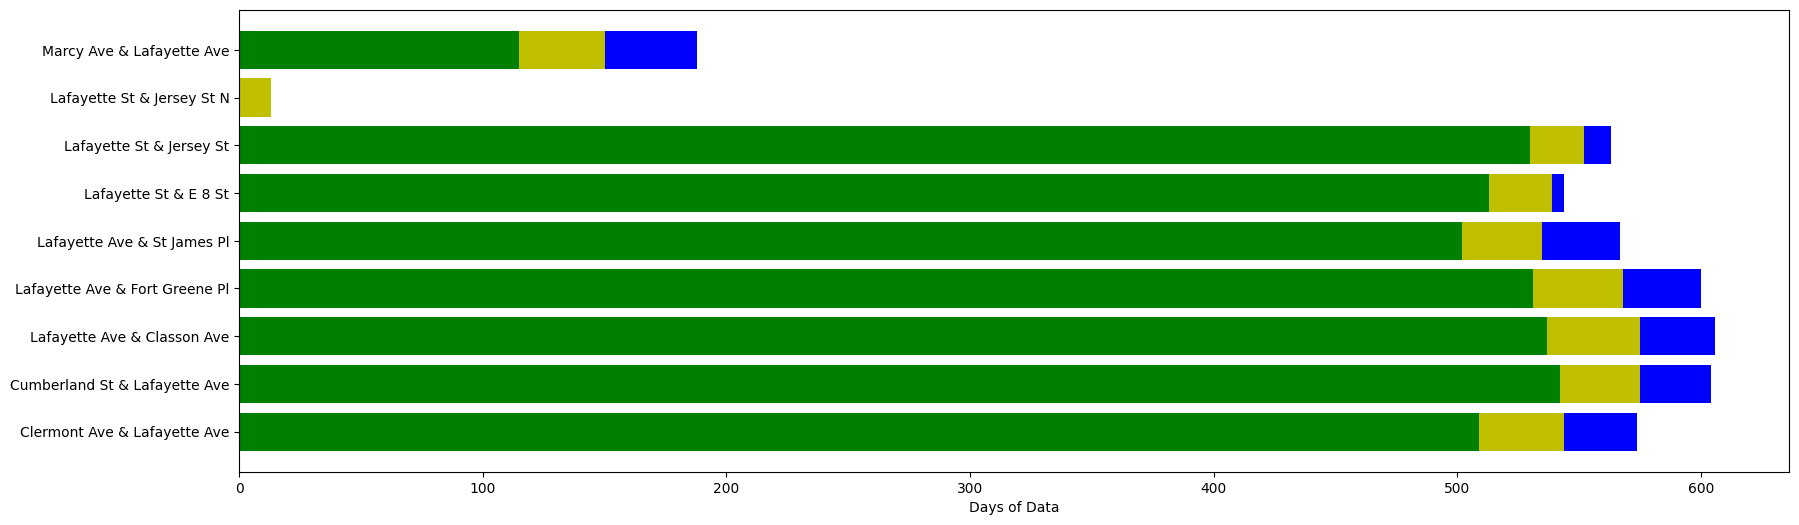

In [76]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

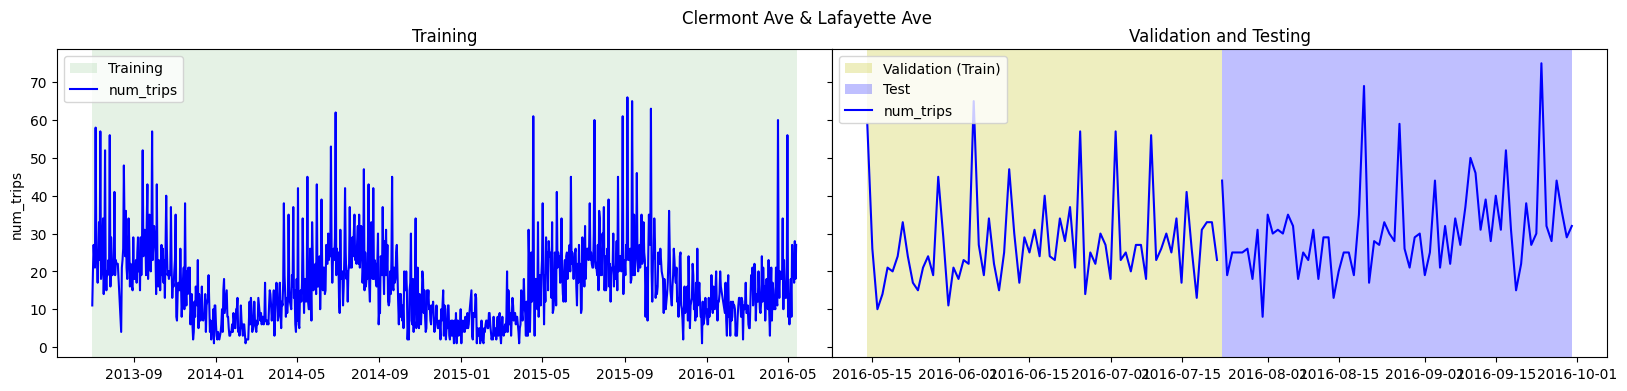

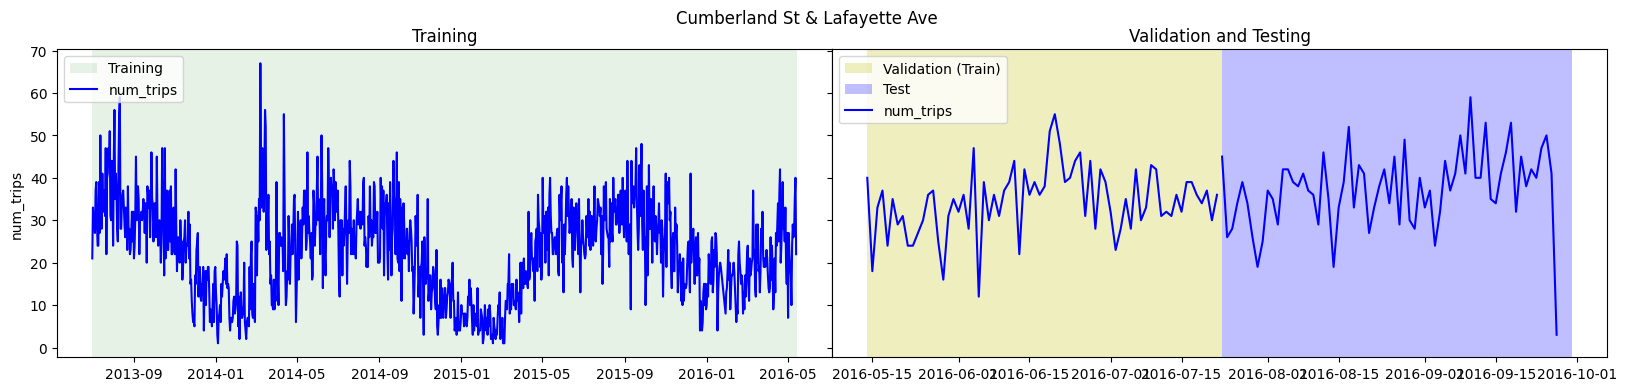

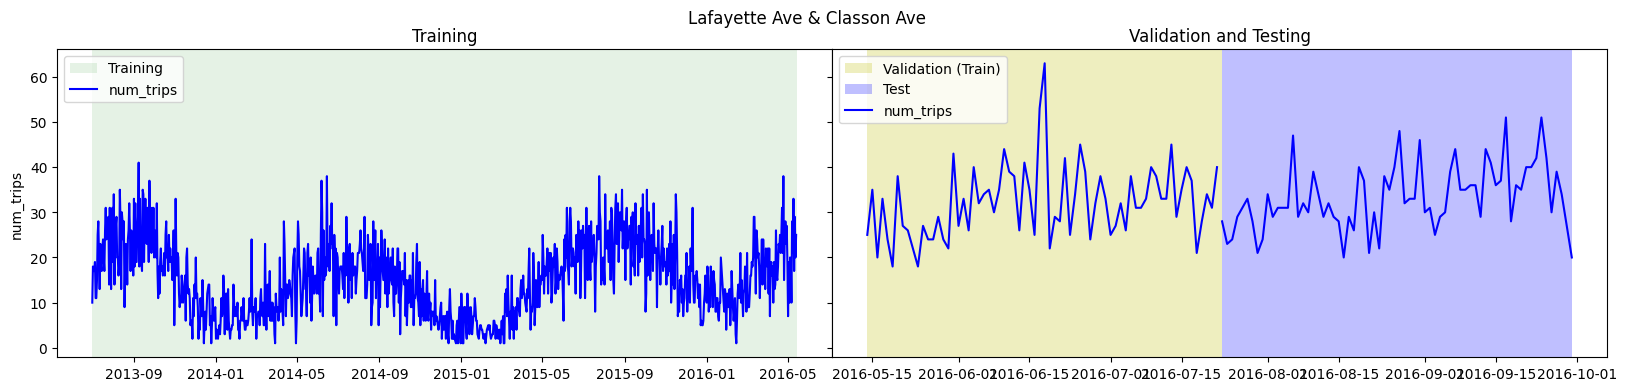

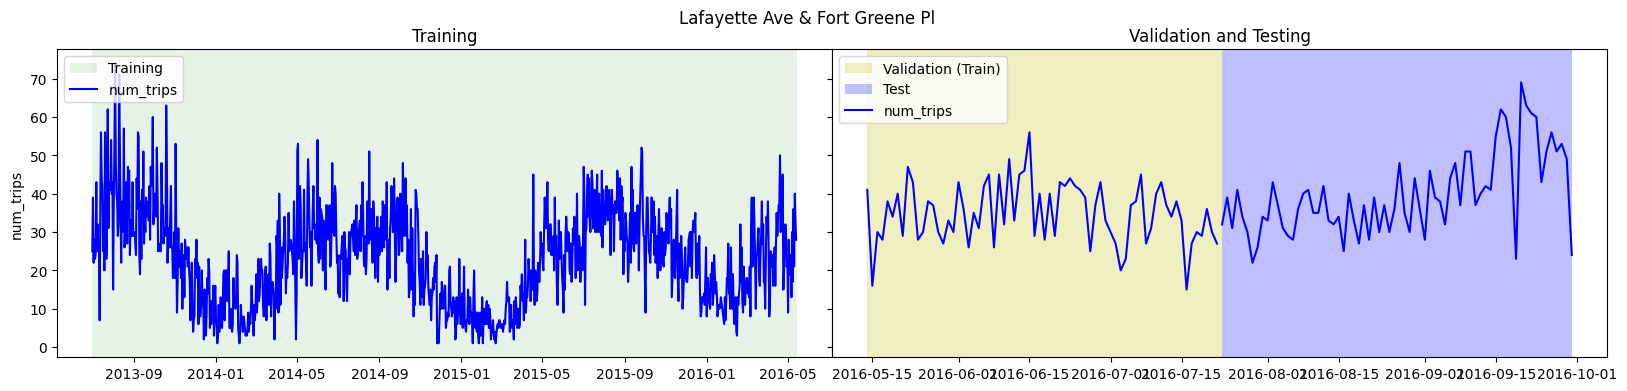

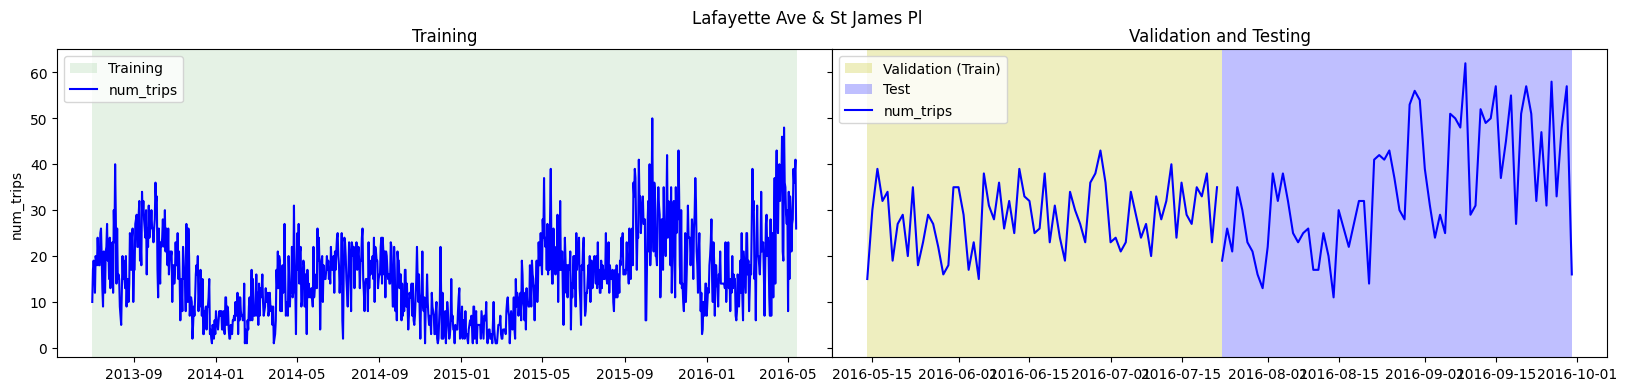

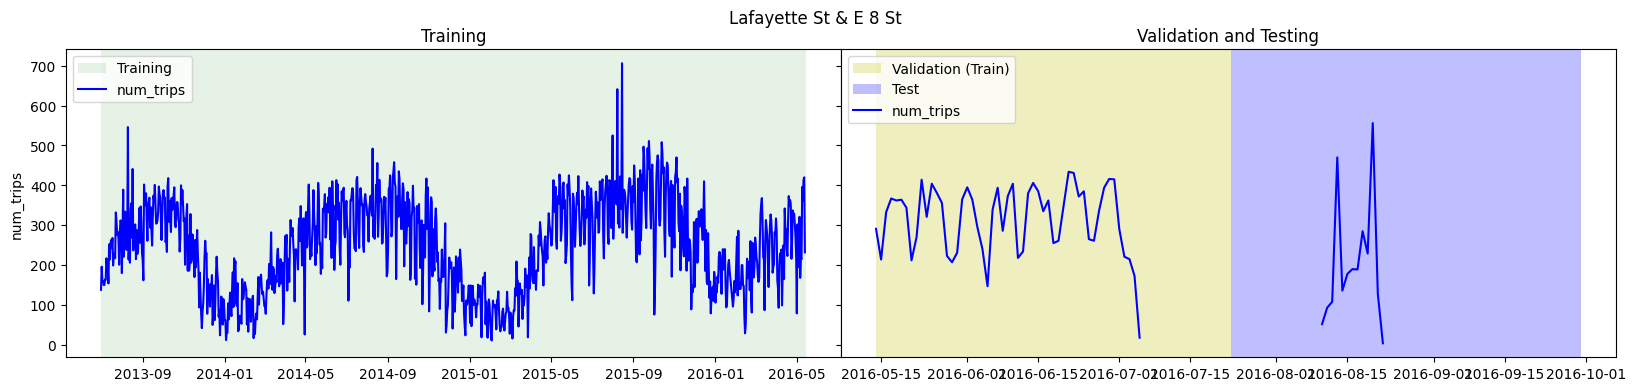

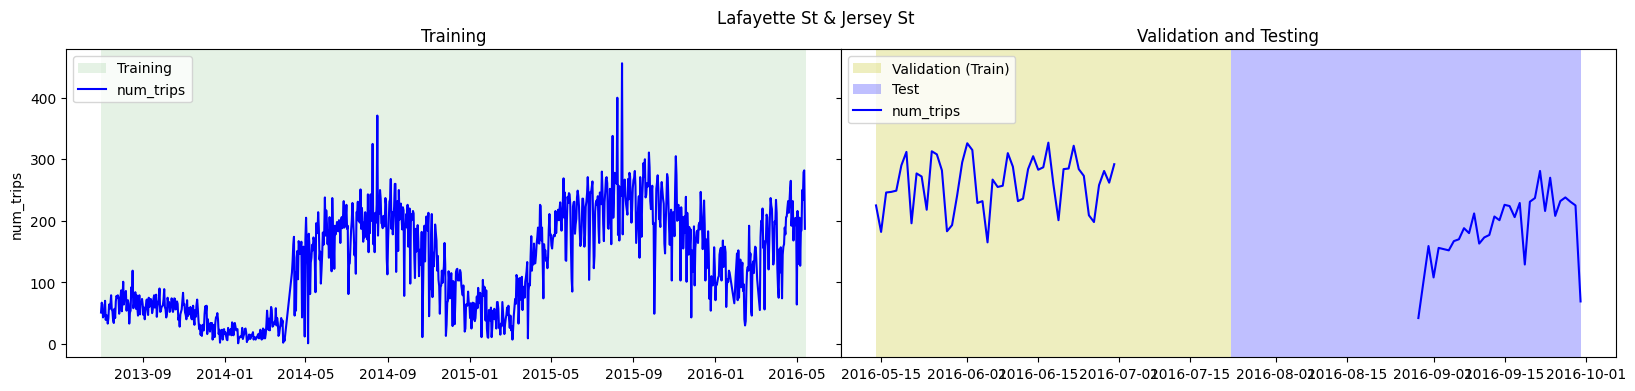

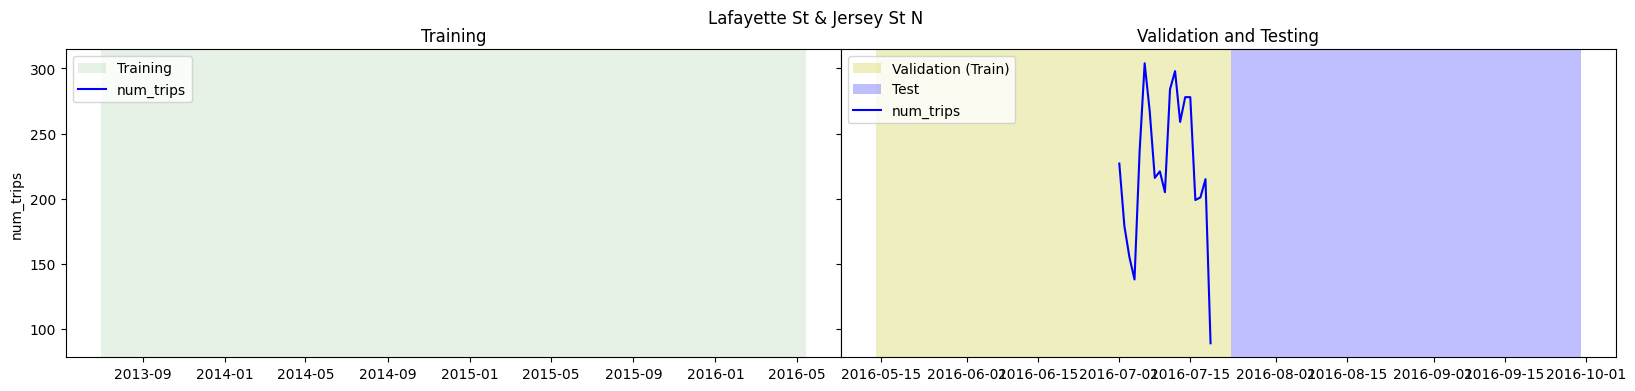

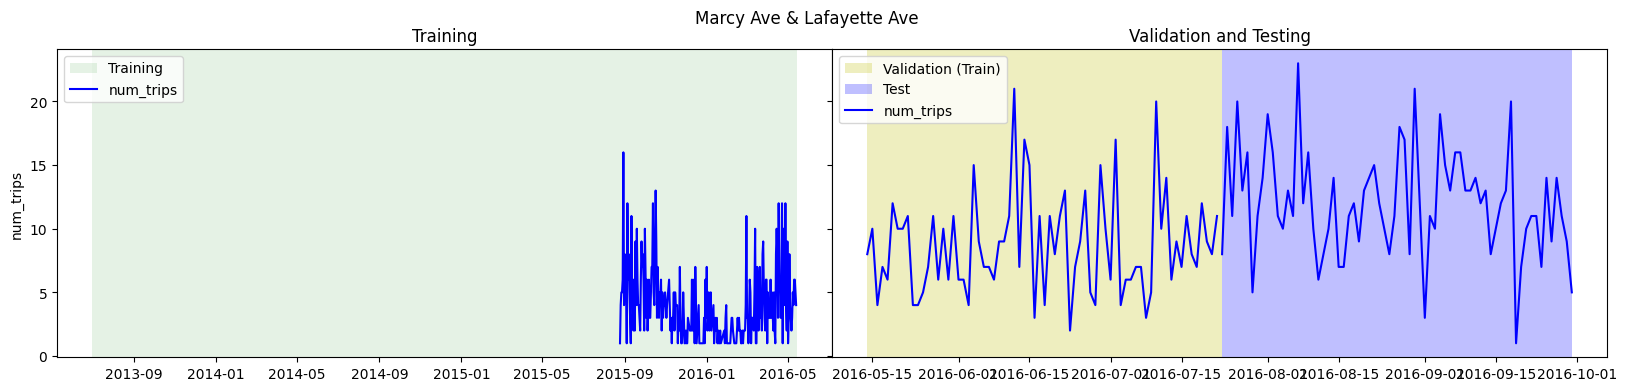

In [77]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

## Review forecast data - Control Group B

In [78]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Clermont Ave & Lafayette Ave,526,35,40,10834
1,Cumberland St & Lafayette Ave,499,37,38,14172
2,Lafayette Ave & Classon Ave,495,32,39,9732
3,Lafayette Ave & Fort Greene Pl,510,33,38,14373
4,Lafayette Ave & St James Pl,528,37,38,10784
5,Lafayette St & E 8 St,531,27,8,142065
6,Lafayette St & Jersey St,497,26,22,75891
7,Lafayette St & Jersey St N,0,6,0,1277
8,Marcy Ave & Lafayette Ave,130,35,32,1182


In [79]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       3716
VALIDATE     268
TEST         255
dtype: int64

In [80]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4239

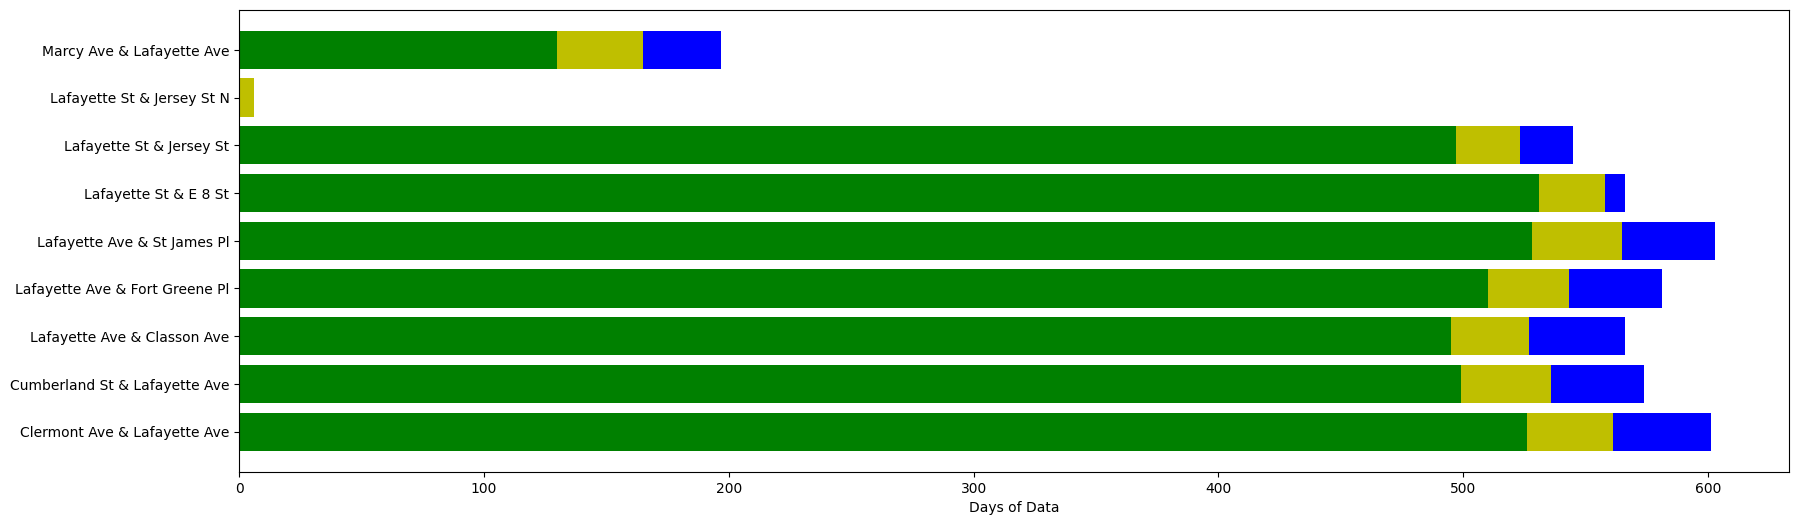

In [81]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

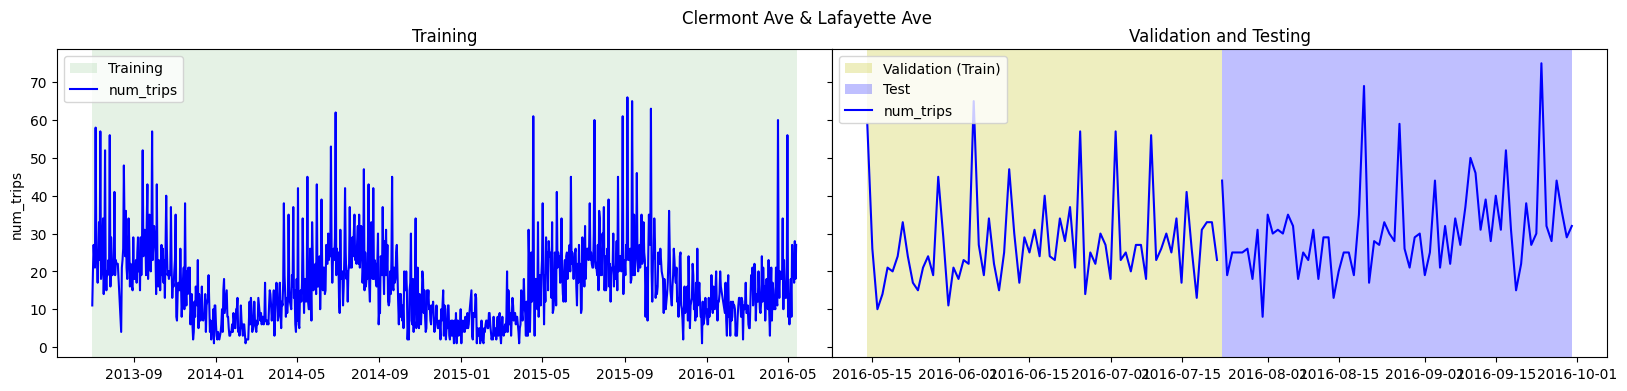

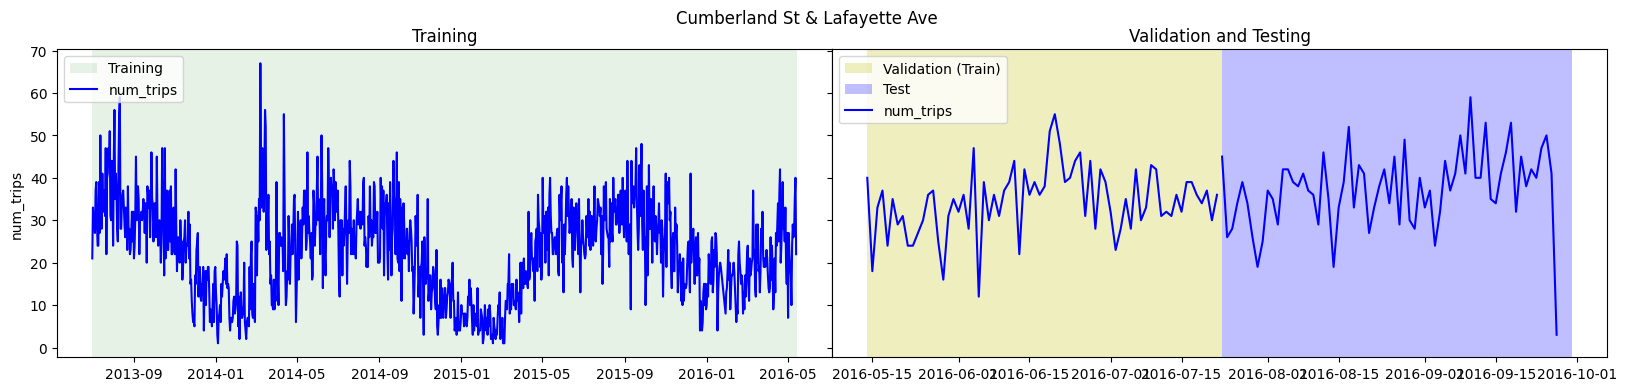

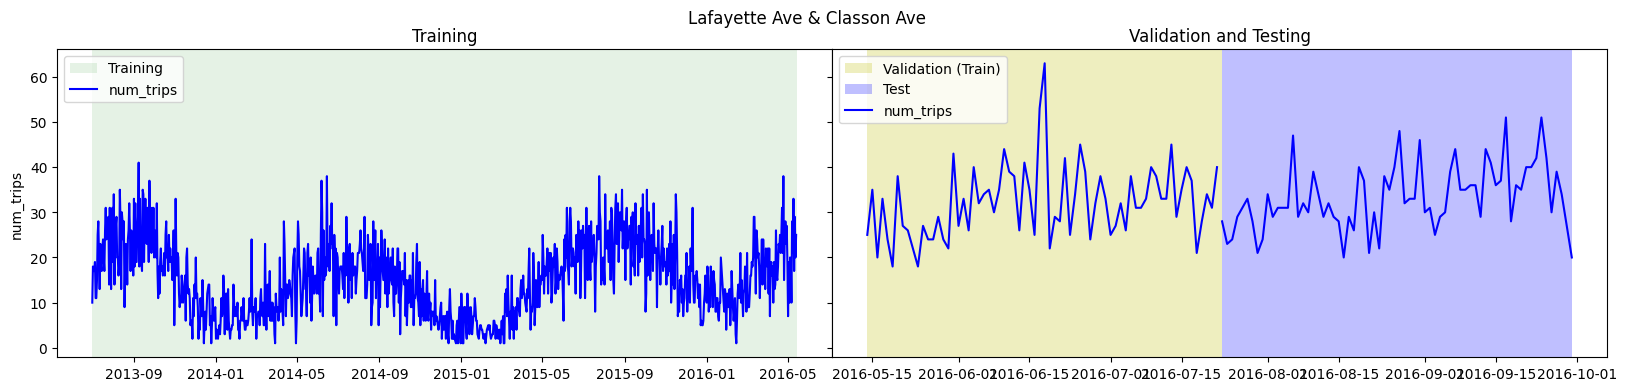

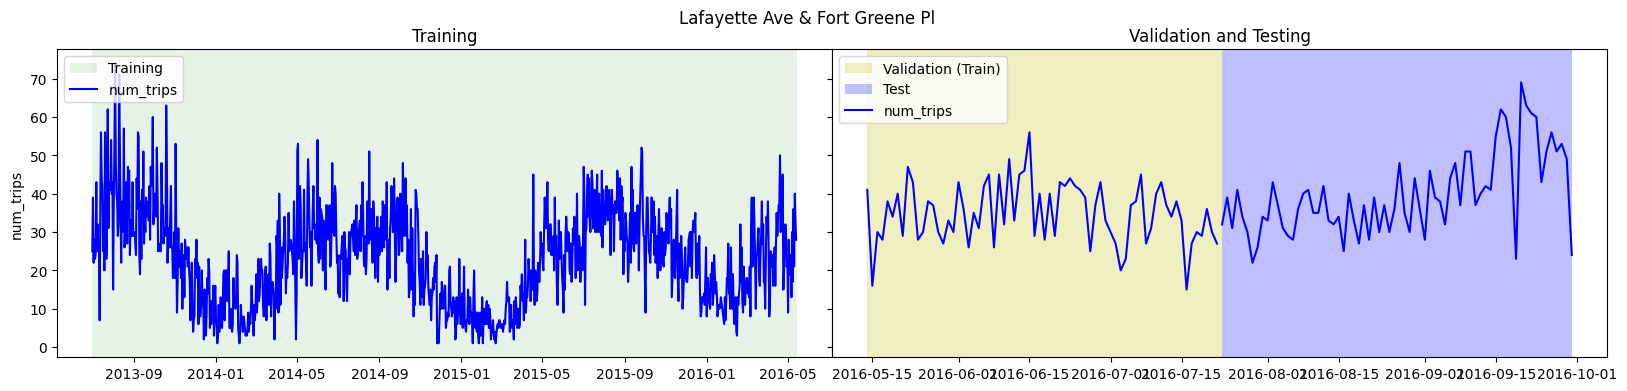

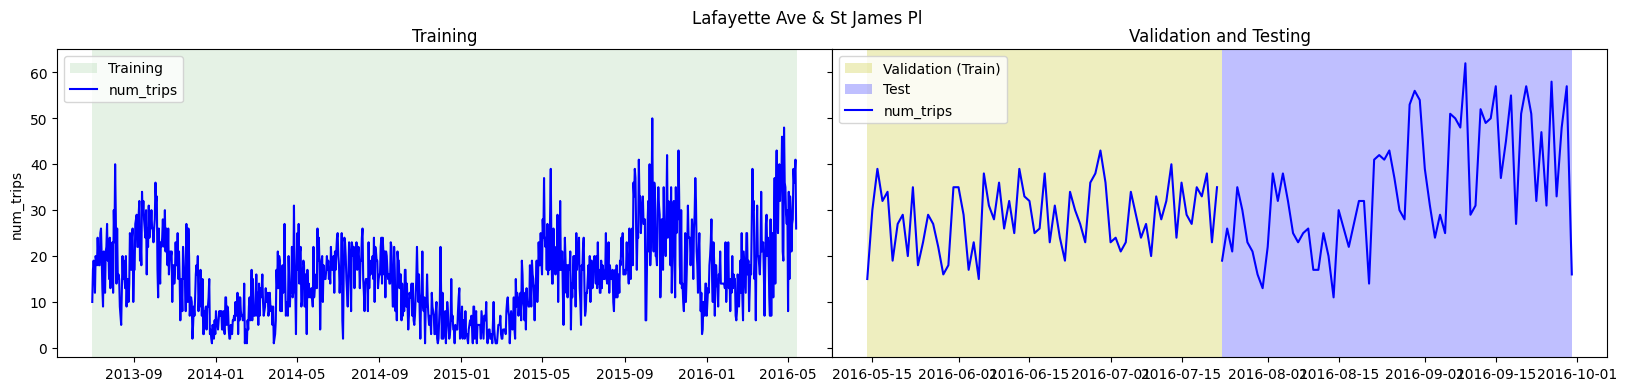

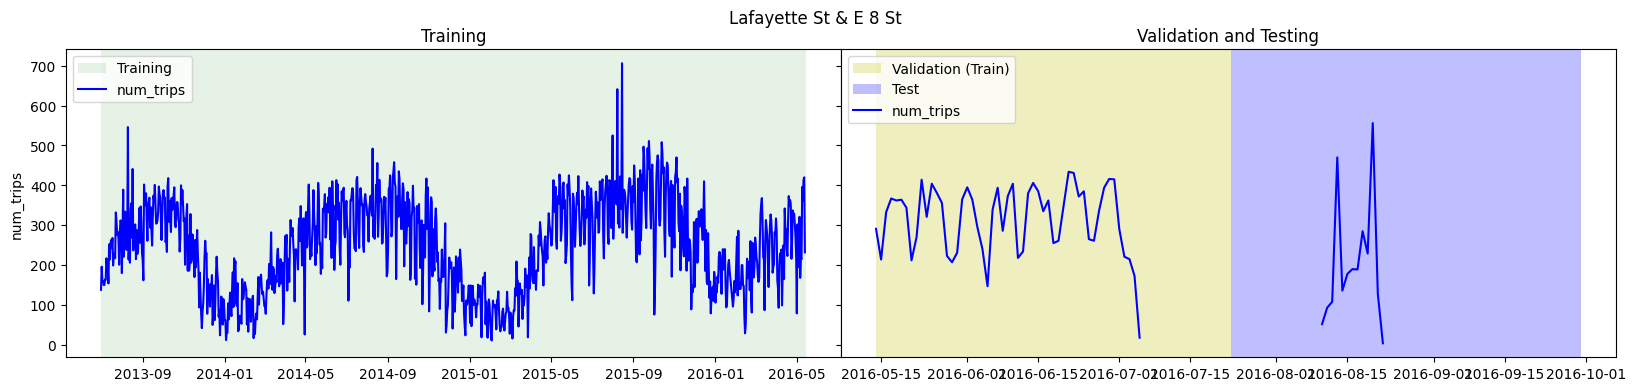

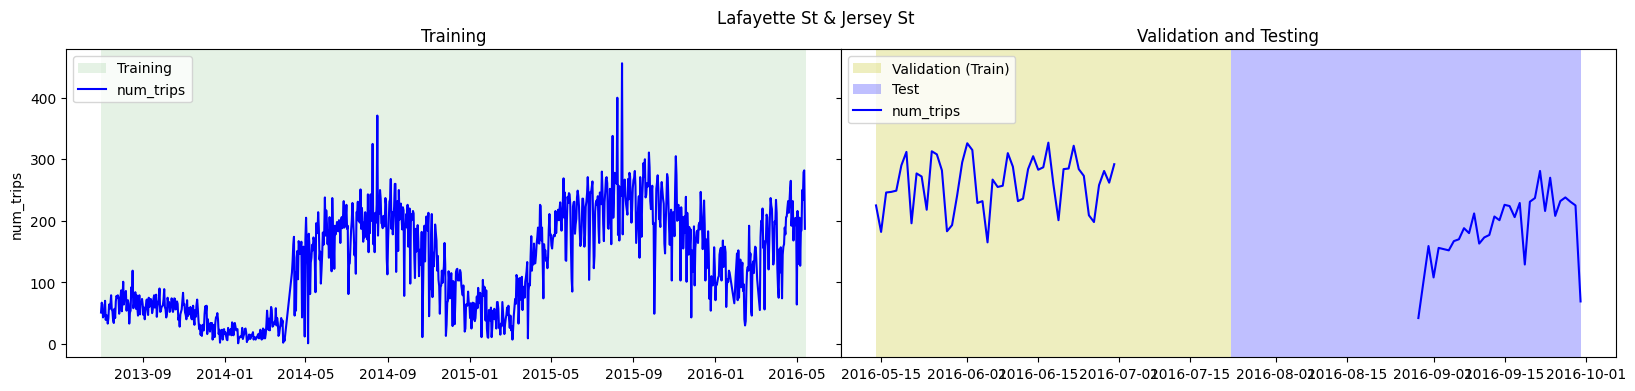

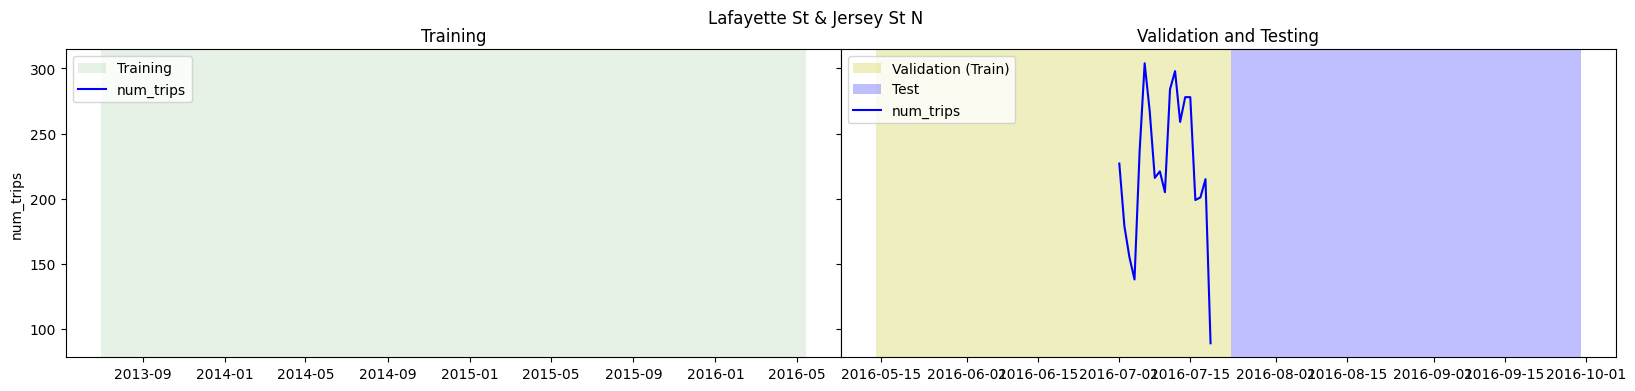

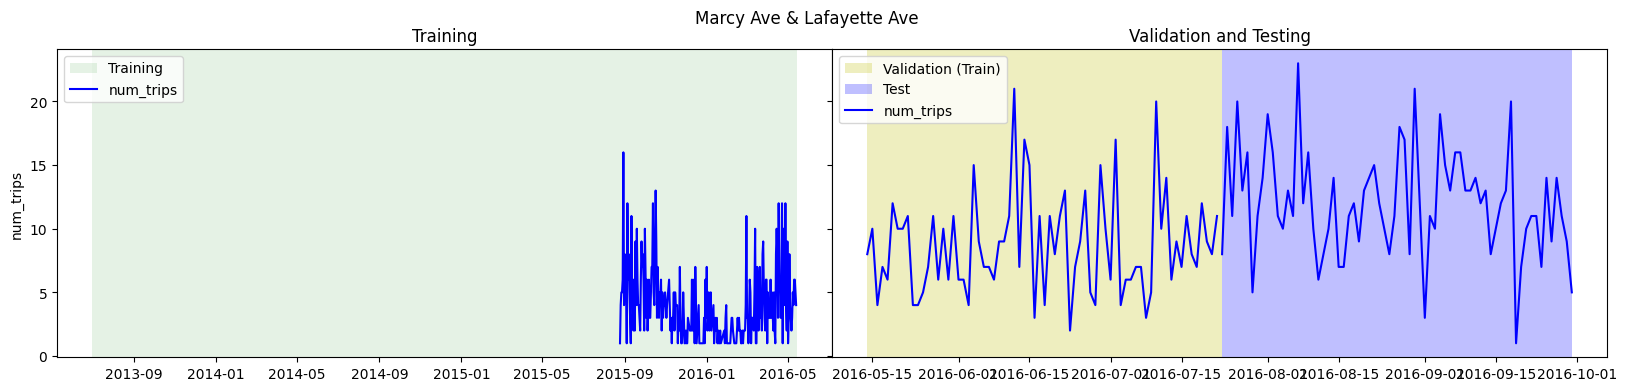

In [82]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

In [45]:
BQ_TABLE

'control_group1'